In [1]:
#adapted from https://github.com/QuCO-CSAM/Solving-Combinatorial-Optimisation-Problems-Using-Quantum-Algorithms/blob/main/QuadraticAssignmentProblem/Code/QAOA.ipynb
#I should probably push this into that repo
import qiskit
from qiskit import Aer
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.circuit.library import RealAmplitudes,TwoLocal #(uses CX entangling) 
from qiskit.aqua import QuantumInstance


# for the part that translates QAP into QUBO
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.applications.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# useful additional packages 
%matplotlib inline
import numpy as np
import pandas as pd
import math

Frankensteining my own version of this code because that is easier g      

In [2]:
# Visualization libraries
import networkx as nx
import matplotlib.pyplot as plt
import QAP_algos as qapalg

In [3]:
%%capture
#qap_problem = "chr8a"
#path_problem = f'QAP_instances/qaplib/{qap_problem}.dat'
#path_solution = f'QAP_instances/qaplib/{qap_problem}.sln'
"""
### Alternatively, to load planted problems, uncomment the next three lines (and comment the lines above)
qap_problem = "problem_1"
path_problem = f'QAP_instances/planted/qap-8/{qap_problem}.dat'
path_solution = f'QAP_instances/planted/qap-8/{qap_problem}.sln'

n, f, d = qap.read_problem_to_lists(path_problem)
n, F, D = qap.read_problem_to_matrices(path_problem)
solution_config, f_optimal = qap.read_solution(path_solution)
print(f"The chosen problem is {qap_problem}, with {n} facilities and {n} locations")
print(f"The optimal objective function is {f_optimal}, with optimal configuration {solution_config}")
"""

In [4]:
def CSVtoNumpyArray(rawdata):
    """
    Input: 
    rawdata = a csv file (insert name as a string)

    Output:
    two numpy matrices in a tuple
    """
    data = pd.read_csv(rawdata)  #Reads the data in as a pandas object
    c = data.columns
    column = int(c[0])
    final_data1 = data.iloc[:column,:].values  #Sets data into a series of numpy arrays of strings
    final_data2 = data.iloc[column:,:].values  #1 is for the first matrix(loc) and 2 is for the second(flow)
    

    #Forms the matrix as a numpy array (easier to work with) instead of an list of lists of strings
    def string_to_integers(final_data):
        matrix = []
        for j in range(column):
            string = final_data[j][0]
            string2 = string.split(" ")
            emptyarray = []
            for i in string2:
                if i != '':
                    emptyarray.append(int(i))
            matrix.append(emptyarray)
        npmatrix = np.array(matrix) 
        return npmatrix
    return string_to_integers(final_data1),string_to_integers(final_data2)

In [5]:
def qap_value(z, MatrixLoc, MatrixFlow):
    """
    Input:
    z (list[int]): list of allocations
    MatrixLoc (numpy array): matrix of distances
    MatrixFlow (numpy array): matrix of flow
    
    Output:
    float: value of the QAP
    """
    matrix_length = len(MatrixLoc)
    x = np.reshape(z, (matrix_length,matrix_length))
    
    total = 0
    for i in range(matrix_length):
        for j in range(matrix_length):
            for k in range(matrix_length):
                for p in range(matrix_length):
                        total += MatrixLoc[i,j]* MatrixFlow[k,p]*x[i,k]*x[j,p]
    
    return total

In [6]:
def qap_feasible(x):
    """
    Input:
    x (numpy.ndarray) : binary string as numpy array.

    Output:
    bool: feasible or not.
    """
    n = int(np.sqrt(len(x)))
    y = np.reshape(x, (n,n))
   
    for i in range(n):
        if sum(y[i, p] for p in range(n)) != 1:
            return False
    for p__ in range(n):
        if sum(y[i, p__] for i in range(n)) != 1:
            return False
    return True

In [7]:
def choose_best_feasible(eigenstates):
    """
    Input:
    eigenstates = dictionary
    
    Output:
    feasible binary 1D numpyarray
    probability of this answer
    """
    bestinarray = sorted(eigenstates.items(), key=lambda item: item[1])[::-1]
    feasible = False
    counter = 0

    feasible=False
    while feasible==False and counter<len(bestinarray):
        #string to array
        bestasint = np.array([0])
        for i in bestinarray[counter][0]:
            bestasint = np.hstack((bestasint, int(i)))
        feasible = qap_feasible(bestasint[1:])
        frequency = bestinarray[counter][1]
        counter += 1
        
    if feasible == False:
        return feasible
    else:
        return bestasint[1:], frequency/total

In [8]:
def read_optimal(ins):
    data = pd.read_csv("initial_point-" + str(ins),header = None)
    n = len(data[0]) - 1
    ans = []
    data[0][0] = data[0][0][1:]
    data[0][n] = data[0][n][:-1]
    for i in data[0]:
        r = i.split(" ")
        for t in r:
            if t!='':
                ans.append(float(t))
    return np.array(ans)

## QAOA function

In [9]:
from qiskit.providers.aer import AerSimulator
from math import pi

In [10]:
def testing_quantum(machine, ins, SPtrial, SHOT, optimal_point, p_depth, number_iterations):
    """
    Input:
    machine: the name of available machine
    ins: the QAP instance
    SPtrial: max_trials for SPSA 
    SHOT: number of shots
    optimal_point: numpy array of optimal points from simulator
    p_depth = parametrized p_depth variable 1-n
    number_iterations: number of iterations for QAOA algorithm
    
    Output:
    outmatrix: 30 * [eigensolution value, time, feasibility]
    (outfile "thirty_trials-<machine name>-<instance name>.csv")
    """
    
    #get matrix
    datamatrix = CSVtoNumpyArray(ins)
    MatrixLoc = datamatrix[0]
    MatrixFlow = datamatrix[1]
    n = len(MatrixLoc)

    # Create an instance of a model and variables.
    thename = "qap" + str(n)
    mdl = Model(name=thename)
    x = {(i,p): mdl.binary_var(name='x_{0}_{1}'.format(i,p)) for i in range(n) for p in range(n)}

    # Object function
    qap_func = mdl.sum(MatrixLoc[i,j]* MatrixFlow[k,p]*x[i,k]*x[j,p] 
                       for i in range(n) for j in range(n) for p in range(n) for k in range(n))
    mdl.minimize(qap_func)

    # Constraints
    for i in range(n):
        mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
    for p in range(n):
        mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)
    print(mdl.export_to_string())
    qubitOp_docplex, offset_docplex = docplex.get_operator(mdl) 

    #Setup QAOA
    seed = 10598
    spsa = SPSA(maxiter=SPtrial)
    print('num of qubits; ', qubitOp_docplex.num_qubits)
    
    #30 trials 
    file = open("thirty_trials-" + str(machine) + "-" + str(ins) ,"w")
    file.write("value,   feasible,   frequency, time, iteration" + "\n")
    ans = np.zeros(5)
    for i in range(number_iterations): #back to 30 bb

            backend = Aer.get_backend('aer_simulator')

            #backend = provider.get_backend(machine)
            #For Aer simulator, need to pass specific options to the instance
            quantum_instance = QuantumInstance(backend=backend,seed_simulator=seed, seed_transpiler=seed, 
                                               skip_qobj_validation = False, shots = SHOT,
                                               backend_options = {'max_parallel_threads ':0,'blocking_enable': True,
                                               'blocking_qubits':20})
            
            qaoa = QAOA(qubitOp_docplex,optimizer=spsa, p=p_depth, quantum_instance=quantum_instance,include_custom=True)
            
            result = qaoa.run(quantum_instance)
            
            #Output processing
            print(' Eigenstate:', result['eigenstate'])
            
            print('QAOA time:', result['optimizer_time'])
            
            n = len(list(result['eigenstate'].values()))
            
            solution = np.hstack((np.array(list(result['eigenstate'].values())).reshape(n,1),
                                  np.array(list(result['eigenstate'].keys())).reshape(n,1)))
            #solution = solution.astype(np.float64)
            
            print(solution)    
            
            for r in solution:
                #feasible_val = feasible or not, val_freq = frequency of value
                # q_time = time to run, i = iteration number
                redux = np.array(list(r[1])).astype(float)
                energy_val = qap_value(redux,np.array(MatrixFlow).astype(float),np.array(MatrixLoc).astype(float))
                feasible_val = qap_feasible(redux)
                val_freq = float(r[0])
                q_time = result['optimizer_time']
                ans = np.vstack((ans,np.array([energy_val,
                                               feasible_val,val_freq,q_time,i])))
                file.write(str(energy_val) + "," + 
                           str(feasible_val) + "," + str(val_freq) + ","+ 
                           str(q_time) + "," + str(i) + "\n")
    return result   

In [11]:
import numba

These are the cells running solutions

In [12]:
%%capture
#3 by 3 thirty trials
# this is still pretty buggy!!!
import logging
logging.basicConfig(level=logging.DEBUG) # log the steps of the algorithm and results
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
machines = 'aer' 
instances = "made3ez.csv"
number_iterations = 30
shots = 1024 #old 1024
optimal_point = read_optimal(instances)
ans = testing_quantum(machines, instances, 1, shots, optimal_point, 1, number_iterations)



In [13]:
col_list = ["value","   feasible","   frequency"," time"," iteration"]
df = pd.read_csv("thirty_trials-aer-made3ez.csv", usecols=col_list)
df = df.rename(columns={'   feasible': 'feasible', '   frequency': 'frequency',' time':'time',' iteration':'iteration'})

In [14]:
#split the data depending on the iterrations on a for loop
df_list = []
for i in range(number_iterations):
    df_list.append(df[df['iteration'] == i])


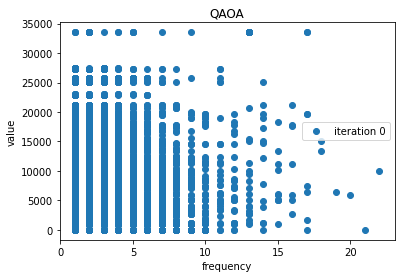

In [15]:
#plot as dots of different colors
#keys are value, feasible, frequency, time, iteration
key1='frequency'
key2='value'
range_to_plot = 1
for i in range(range_to_plot):
    plt.scatter(df[key1],df[key2],cmap='coolwarm') 
plt.xlabel(key1)
plt.ylabel(key2)
#legend
plt.legend(["iteration "+ str(i) for i in range(number_iterations)])
#legend title
plt.title('QAOA')
plt.show()


In [16]:
ans['eigenstate']

{'001010000': 1,
 '101110001': 2,
 '101101111': 1,
 '110000100': 5,
 '001100001': 2,
 '100100010': 3,
 '010001100': 2,
 '110010010': 6,
 '010100110': 4,
 '000011111': 7,
 '101010001': 3,
 '101101101': 2,
 '110000110': 5,
 '011111100': 1,
 '000100110': 2,
 '000111010': 8,
 '100001110': 5,
 '001110111': 5,
 '100010110': 1,
 '001001011': 4,
 '010010101': 7,
 '110101111': 2,
 '001100110': 1,
 '101010100': 1,
 '000011100': 2,
 '011001100': 1,
 '011100001': 4,
 '000101101': 3,
 '001111110': 1,
 '100000111': 1,
 '100011101': 3,
 '001000000': 1,
 '100110110': 2,
 '000010111': 2,
 '100101010': 3,
 '001101011': 6,
 '001110001': 1,
 '001001101': 2,
 '100001100': 1,
 '100010000': 8,
 '101010000': 4,
 '101101110': 1,
 '110000111': 5,
 '100100001': 1,
 '110010111': 7,
 '001101010': 4,
 '100100100': 6,
 '101010101': 1,
 '000011011': 5,
 '100111100': 6,
 '110010000': 6,
 '101011101': 2,
 '000010011': 4,
 '100110010': 8,
 '111001011': 5,
 '000111011': 1,
 '000100101': 1,
 '010100010': 1,
 '101001111': 

In [39]:
names = list(ans['eigenstate'].keys())
values = list(ans['eigenstate'].values())


In [41]:
import plotly.graph_objects as go

# Specify the plots
bar_plots = [
    go.Bar(x=names, y=values, name='Data', marker=go.bar.Marker(color='#0343df')),
]
# Customise some display properties
layout = go.Layout(
    title=go.layout.Title(text="Frequency of different QAOA measurements", x=0.5),
    yaxis_title="Frequency",
    xaxis_tickmode="array",
    xaxis_tickvals=list(range(len(names))),
    xaxis_ticktext=tuple(names),
)
# Make the multi-bar plot
fig = go.Figure(data=bar_plots, layout=layout)
# Tell Plotly to render it
fig.show()

In [40]:
print(names)

['001010000', '101110001', '101101111', '110000100', '001100001', '100100010', '010001100', '110010010', '010100110', '000011111', '101010001', '101101101', '110000110', '011111100', '000100110', '000111010', '100001110', '001110111', '100010110', '001001011', '010010101', '110101111', '001100110', '101010100', '000011100', '011001100', '011100001', '000101101', '001111110', '100000111', '100011101', '001000000', '100110110', '000010111', '100101010', '001101011', '001110001', '001001101', '100001100', '100010000', '101010000', '101101110', '110000111', '100100001', '110010111', '001101010', '100100100', '101010101', '000011011', '100111100', '110010000', '101011101', '000010011', '100110010', '111001011', '000111011', '000100101', '010100010', '101001111', '010001101', '101011010', '110010101', '001101100', '111001101', '101011011', '000010101', '100110100', '111011010', '110110011', '011100110', '011001101', '000101100', '110100101', '100011110', '001000001', '001111101', '011100111'

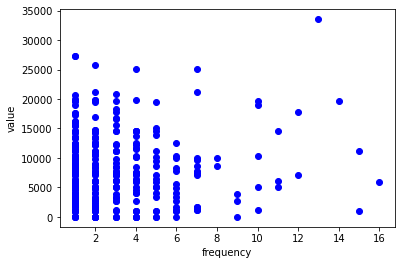

In [18]:
#keys are value, feasible, frequency, time, iteration
key1 = 'frequency'
key2 = 'value'
import matplotlib.pyplot as plt
testt = df_list[1][key1]
testt2 = df_list[1][key2]
plt.plot(testt,testt2,'bo')
plt.xlabel(key1)
plt.ylabel(key2)
plt.show()

In [19]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.10.2', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': '0.9.5', 'qiskit': '0.34.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.3.0', 'qiskit-machine-learning': None}